<a href="https://colab.research.google.com/github/Falconwatch/MKBhack/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 29 kB/s 


In [40]:
import pandas as pd
import datetime
import missingno as msno
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
parser = lambda date: None if pd.isna(date) else datetime.datetime.strptime(date, '%d%b%Y:%H:%M:%S')

train = pd.read_csv("train_dataset_hackathon_mkb.csv", encoding='cp1251', sep=';',
                    parse_dates=["SIGN_DATE", "DATEFIRSTREG", "TAXREG_REGDATE", "BIRTHDATE", "TAXREGPAY_REGDATE"], 
                    date_parser=parser)
test = pd.read_csv("test_dataset_hackathon_mkb.csv", encoding='cp1251', sep=';',
                    parse_dates=["SIGN_DATE", "DATEFIRSTREG", "TAXREG_REGDATE", "BIRTHDATE", "TAXREGPAY_REGDATE"], 
                   date_parser=parser)

train["is_train"] = 1
test["is_train"] = 0

data = pd.concat([train, test])

# Общие преобразования

## переход к формату клиент - дата **выдачи**

### Разметка дефолта

In [69]:
#Клиент на дату с указание таргета и числа договоров в дату
client_data = data.groupby(["id_client", "SIGN_DATE"]).agg({"TARGET":"mean", "id_client":"count"})
client_data.columns = ["target", "issues_this_day"]
client_data.head(2)

,,target,issues_this_day
id_client,SIGN_DATE,,
1,2018-05-15,1.0,1
2,2018-02-28,0.0,1


In [70]:
# Дефолт не на уровне клиента. 14 таких клиентов
client_data[(client_data["target"]>0) & (client_data["target"]<1)].shape

(14, 2)

### Обрабатываем все нумерик фичи

In [71]:
client_data_numeric = data.groupby(["id_client", "SIGN_DATE"]).max(numeric_only=True)
client_data_numeric = client_data_numeric.drop(["id_contract"], axis=1)
client_data_numeric.head(2)

,,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,F2220,F2300,...,COUNTBRANCHEGRUL,TELEPHONECOUNT,MANAGERCOUNTINCOUNTRY,MANAGERCOUNTINREGION,MANAGERINNCOUNT,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,is_train
id_client,SIGN_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018-05-15,0,1.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,6121000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924000.0,NaN,924000.0,NaN,NaN,7045000.0,7045000.0,NaN,32078000.0,27921000.0,4157000.0,NaN,NaN,4157000.0,...,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,22.0,10.0,22265508.0,242.0,10.0,111.0,90.0,104344311.0,NaN,NaN,NaN,NaN,1
2,2018-02-28,0,0.0,14626000.0,NaN,14414000.0,NaN,212000.0,NaN,NaN,14939000.0,8521000.0,NaN,6395000.0,NaN,23000.0,NaN,18901000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10664000.0,8995000.0,1669000.0,NaN,NaN,29565000.0,29565000.0,NaN,28874000.0,26330000.0,2544000.0,NaN,NaN,2126000.0,...,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,16765.0,0.0,1.0,0.0,1.0,16765.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,13.0,13.0,41353573.0,88.0,2.0,41.0,41.0,178087244.0,NaN,NaN,1.0,NaN,1


### Обрабатываем строковые фичи

In [72]:
dts = data.dtypes
object_columns = dts[dts=="object"].index.values
object_columns

array(['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE',
       'OKVED_CODE', 'SEX_NAME', 'CITIZENSHIP_NAME'], dtype=object)

In [73]:
for oc in object_columns:
  data[oc] = data[oc].astype(str)

In [74]:
client_obj_features_list = list()
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKFS_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKOPF_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKOGU_GROUP"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["WORKERSRANGE"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["OKVED_CODE"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["SEX_NAME"].max())
client_obj_features_list.append(data.groupby(["id_client", "SIGN_DATE"])["CITIZENSHIP_NAME"].max())

In [75]:
client_obj_features = pd.concat(client_obj_features_list, axis=1)

### Формируем итоговый набор по клиенту

In [76]:
t = client_data.merge(client_data_numeric, left_index=True, right_index=True)
final_client_data = t.merge(client_obj_features, left_index=True, right_index=True)

In [77]:
final_client_data.head()

,,target,issues_this_day,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,F2210,...,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,AGE,is_train,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE,OKVED_CODE,SEX_NAME,CITIZENSHIP_NAME
id_client,SIGN_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2018-05-15,1.0,1,0,1.0,10000.0,NaN,10000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,NaN,NaN,NaN,7035000.0,NaN,6121000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924000.0,NaN,924000.0,NaN,NaN,7045000.0,7045000.0,NaN,32078000.0,27921000.0,4157000.0,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,5.0,22.0,10.0,22265508.0,242.0,10.0,111.0,90.0,104344311.0,NaN,NaN,NaN,NaN,1,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,6 .. 10,43.11,nan,nan
2,2018-02-28,0.0,1,0,0.0,14626000.0,NaN,14414000.0,NaN,212000.0,NaN,NaN,14939000.0,8521000.0,NaN,6395000.0,NaN,23000.0,NaN,18901000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10664000.0,8995000.0,1669000.0,NaN,NaN,29565000.0,29565000.0,NaN,28874000.0,26330000.0,2544000.0,NaN,...,1.0,16765.0,0.0,1.0,0.0,1.0,16765.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,13.0,13.0,41353573.0,88.0,2.0,41.0,41.0,178087244.0,NaN,NaN,1.0,NaN,1,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,6 .. 10,31.09,nan,nan
3,2019-03-25,1.0,1,0,1.0,3745000.0,NaN,3745000.0,NaN,NaN,NaN,NaN,9131000.0,888000.0,67000.0,6261000.0,NaN,645000.0,1270000.0,40000.0,40000.0,NaN,NaN,NaN,NaN,10113000.0,10113000.0,NaN,NaN,2723000.0,NaN,2723000.0,NaN,NaN,12876000.0,12876000.0,120000.0,378000.0,258000.0,73000.0,2000.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,1,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,0 .. 5,10.11,nan,nan
4,2019-05-14,NaN,1,0,NaN,2177000.0,NaN,2177000.0,NaN,NaN,NaN,NaN,6506000.0,2598000.0,NaN,1722000.0,NaN,2186000.0,NaN,6956000.0,10000.0,NaN,NaN,NaN,6946000.0,NaN,NaN,NaN,NaN,1727000.0,292000.0,1435000.0,NaN,NaN,8683000.0,8683000.0,-1145000.0,33927000.0,35072000.0,-1145000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,51 .. 100,18.12,nan,nan
5,2019-01-21,0.0,1,0,0.0,87239000.0,NaN,86087000.0,NaN,NaN,262000.0,890000.0,75181000.0,23412000.0,NaN,29428000.0,10200000.0,12141000.0,NaN,134209000.0,10518000.0,NaN,NaN,NaN,104475000.0,NaN,NaN,NaN,NaN,28211000.0,NaN,28111000.0,NaN,100000.0,162420000.0,162420000.0,104340000.0,871384000.0,767044000.0,40236000.0,64104000.0,...,1.0,156944.0,1.0,70.0,22774722.0,6.0,156944.0,2.0,1.0,0.0,1.0,1.0,338369.0,22.0,0.0,19.0,17.0,3971575.0,308.0,1.0,289.0,303.0,59038624.0,1866.0,3.0,1716.0,1522.0,365441112.0,NaN,NaN,2.0,NaN,1,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,251 .. 500,10.51,nan,nan


## Чистка аномалий

In [78]:
#клиент 11209 то ИП, то ЮЛ и при этом существует только в трейне - дропаем
final_client_data = final_client_data.drop(11209)

## Генерация фичей

In [82]:
#выдано до этого дня
issues_cumsum = final_client_data.groupby("id_client")["issues_this_day"].transform(pd.Series.cumsum)
final_client_data["issues_cumsum"] = issues_cumsum - final_client_data["issues_this_day"]

# Разбиение на ИП/ЮЛ
Посмотрим целесообразность разбиения на две модели

In [84]:
ip_data = final_client_data.loc[final_client_data["IP_flag"]==1]
ul_data = final_client_data.loc[final_client_data["IP_flag"]==0]

In [85]:
#msno.bar(ip_data)
ip_data["TARGET"].mean()

0.29518469656992086

In [86]:
#msno.bar(ul_data)
ul_data["TARGET"].mean()

0.3570138943402151

Ожидаемо видим необходимость разделить данные на два потока

# ИП

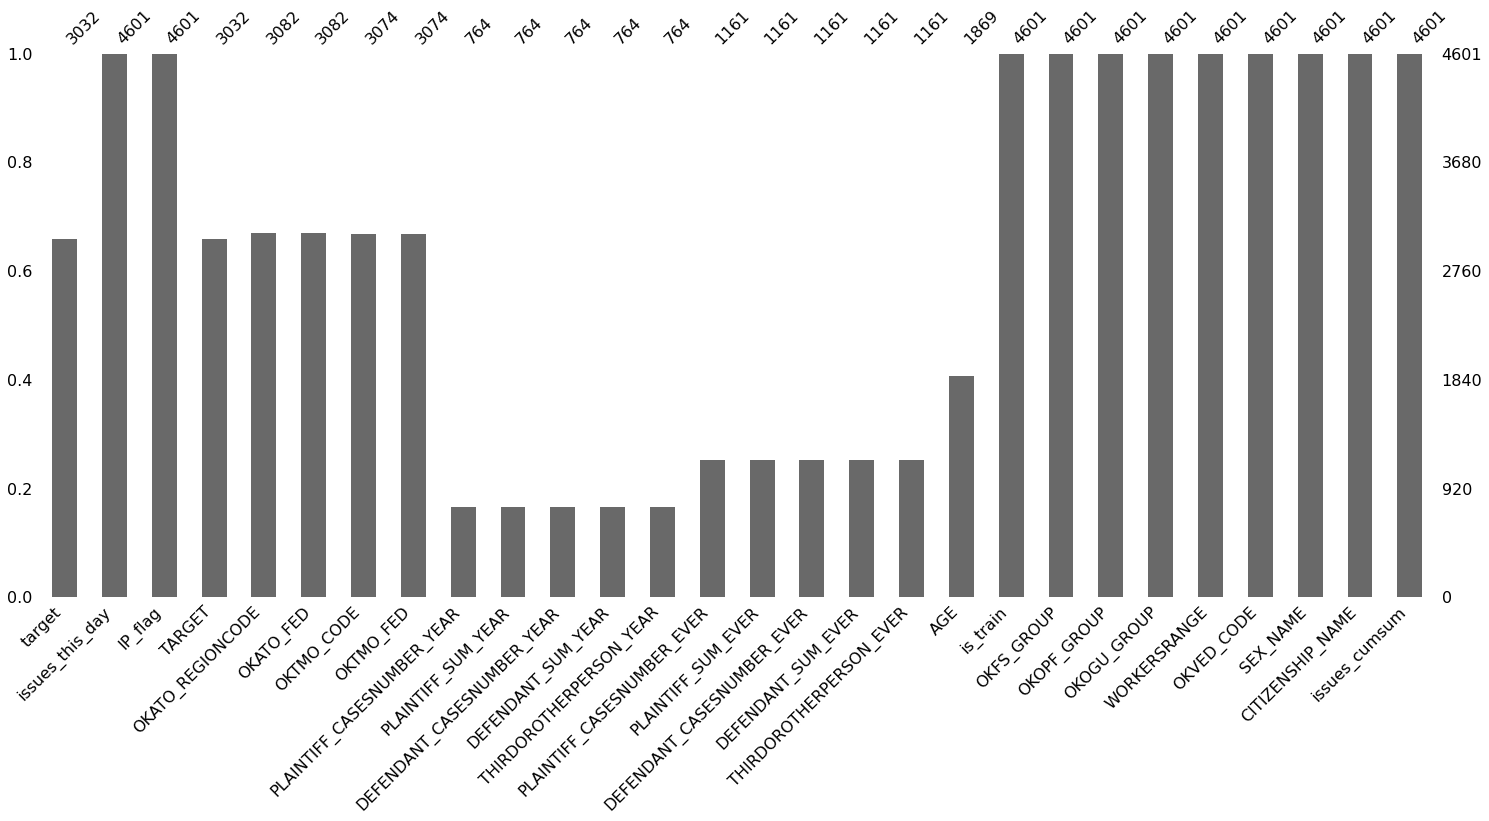

In [87]:
ip_columns_count = ip_data.count()
ip_columns = ip_columns_count[ip_columns_count>0].index.values

ip_data = ip_data[ip_columns]

msno.bar(ip_data)

## Генерация фичей

## Модель

In [98]:
# подготавливаем датасеты
ip_test = ip_data[ip_data["is_train"]==0]
ip_train_and_val = ip_data[ip_data["is_train"]==1]

In [100]:
ip_train, ip_val  = train_test_split(ip_train_and_val, stratify=ip_train_and_val["target"])

In [101]:
from catboost import Pool

In [105]:
dataset = Pool(ip_train_and_val, "target", cat_features = ["OKFS_GROUP", "OKOPF_GROUP",                    
"OKOGU_GROUP", "WORKERSRANGE", "OKVED_CODE", "SEX_NAME","CITIZENSHIP_NAME"])

CatBoostError: ignored

In [104]:
ip_train_and_val.dtypes

target                        float64
issues_this_day                 int64
IP_flag                         int64
TARGET                        float64
OKATO_REGIONCODE              float64
OKATO_FED                     float64
OKTMO_CODE                    float64
OKTMO_FED                     float64
PLAINTIFF_CASESNUMBER_YEAR    float64
PLAINTIFF_SUM_YEAR            float64
DEFENDANT_CASESNUMBER_YEAR    float64
DEFENDANT_SUM_YEAR            float64
THIRDOROTHERPERSON_YEAR       float64
PLAINTIFF_CASESNUMBER_EVER    float64
PLAINTIFF_SUM_EVER            float64
DEFENDANT_CASESNUMBER_EVER    float64
DEFENDANT_SUM_EVER            float64
THIRDOROTHERPERSON_EVER       float64
AGE                           float64
is_train                        int64
OKFS_GROUP                     object
OKOPF_GROUP                    object
OKOGU_GROUP                    object
WORKERSRANGE                   object
OKVED_CODE                     object
SEX_NAME                       object
CITIZENSHIP_

In [41]:
clf = CatBoostClassifier()
clf.fit(ip_X_train, ip_y_train)

CatBoostError: ignored

# ЮЛ

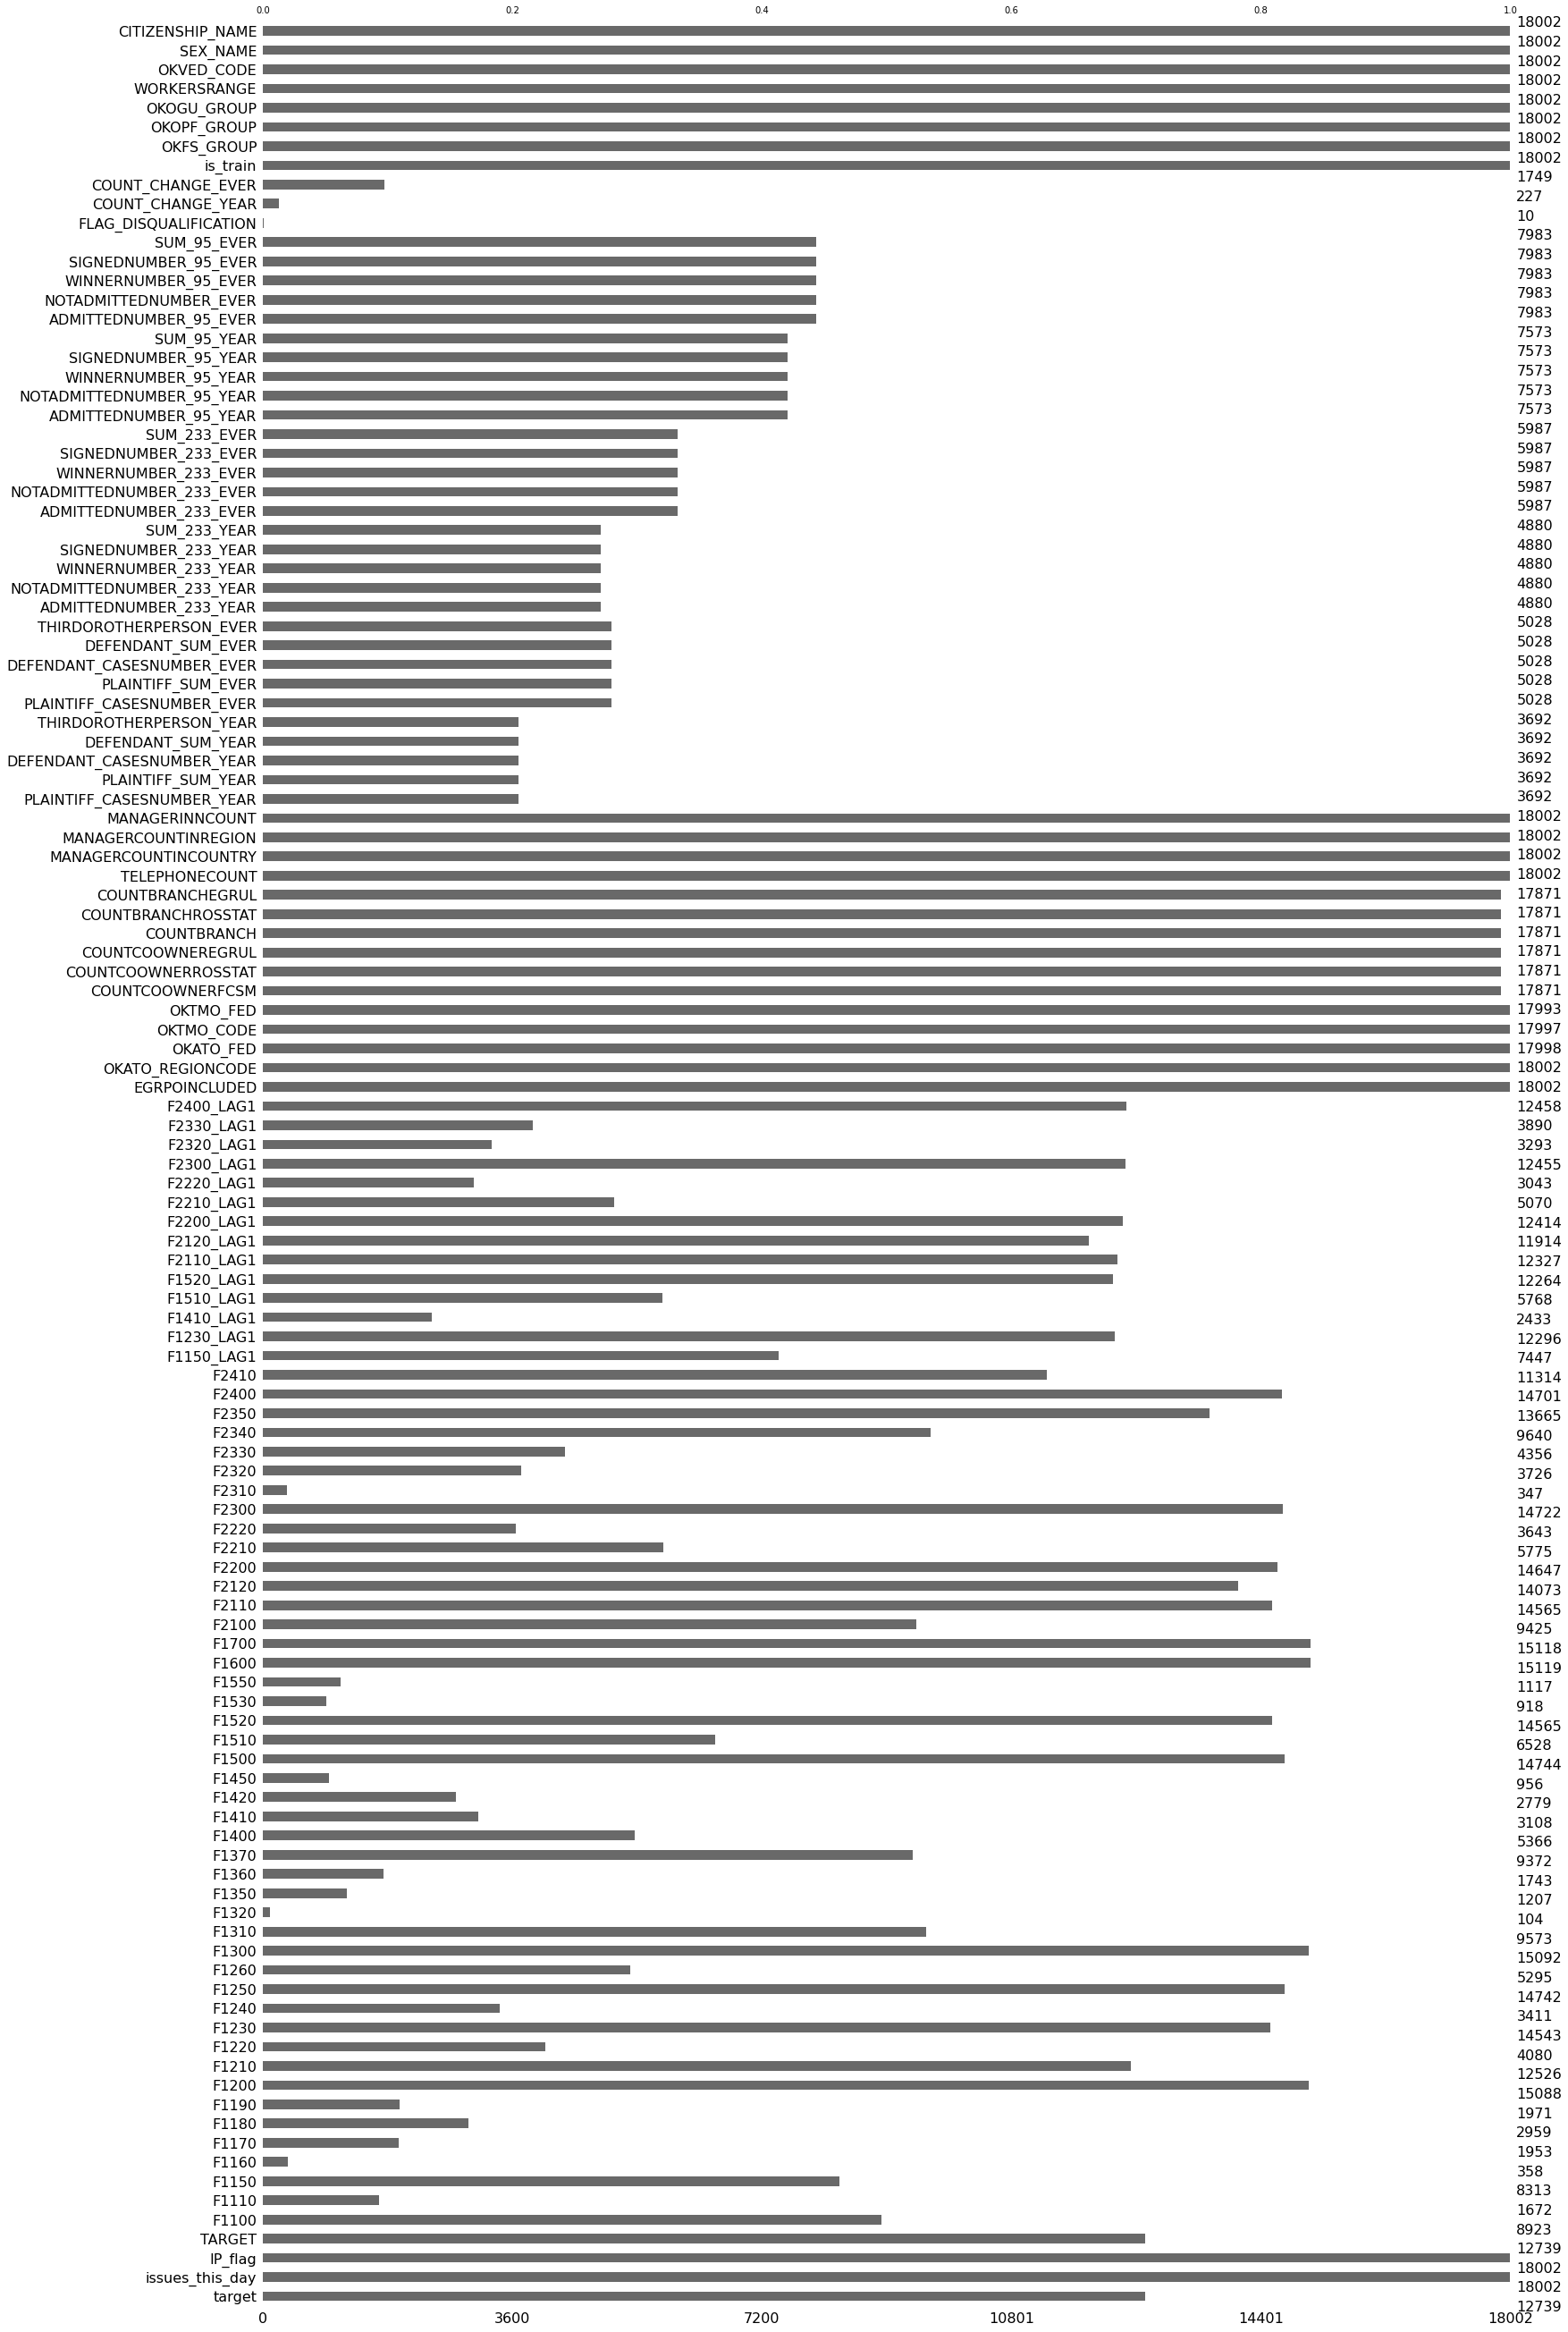

In [19]:
ul_columns_count = ul_data.count()
ul_columns = ul_columns_count[ul_columns_count>0].index.values

ul_data = ul_data[ul_columns]

msno.bar(ul_data)